# Изучение поведения пользователей мобильного приложения продаж продуктов питания

Задача — разобраться как ведут себя пользователи мобильного приложения. Изучите воронку продаж и после этого исследовать результаты A/A/B-эксперимента.

- Первый этап - изучение общий информации.
- Второй этап - предобработка данных.
- Третий этап - изучение воронки событий.
- Четвертый этап - изучение результатов эксперимента.
- Пятый этап - общий вывод. 

Среди данных у нас есть — название события, уникальный идентификатор пользователя, время события, номер эксперимента.

##   Изучение общий информации. 

In [1]:
import pandas as pd
import datetime as dt
from scipy import stats as st
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
import scipy.stats as stats
import math as mth
import plotly.express as px
from plotly import graph_objects as go

In [2]:
try:
    data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
except:
     data = pd.read_csv('C:\\Users\\User\\Documents\\Phyton\\logs_exp.csv', sep='\t')
            
display(data.head(10))

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Пропусков нет, нужно изменить названия колонок для большего удобства и тип даты и времени.

## Предобработка данных.

### Подготовка данных

In [4]:
data = data.rename(                   
    columns={'EventName' : 'event_name', 'DeviceIDHash' : 'device_id_hash', 
            'EventTimestamp' : 'event_timestamp', 'ExpId' : 'exp_id'}
    )

In [5]:
print(data.isna().sum())
print('Количество дубликатов:', data.duplicated().sum())

event_name         0
device_id_hash     0
event_timestamp    0
exp_id             0
dtype: int64
Количество дубликатов: 413


In [6]:
data = data.drop_duplicates().reset_index()
data = data.iloc[: , 1:]

In [7]:
print(data.info())
print('Количество дубликатов:', data.duplicated().sum());

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   event_name       243713 non-null  object
 1   device_id_hash   243713 non-null  int64 
 2   event_timestamp  243713 non-null  int64 
 3   exp_id           243713 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.4+ MB
None
Количество дубликатов: 0


In [8]:
data['event_timestamp'] = data['event_timestamp'].astype(int)

In [9]:
data['event_timestamp'] = pd.to_datetime(data['event_timestamp'], unit='s')
data['event_timestamp'].dtype;
#data.info()

In [10]:
#print(data)

In [11]:
#convert datetime column to just date
data['date'] = pd.to_datetime(data['event_timestamp']).dt.date
display(data)

,event_name,device_id_hash,event_timestamp,exp_id,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25
...,...,...,...,...,...
243708,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07
243709,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07
243710,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07
243711,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07


In [12]:
#создаем таблицу с группами и id пользователей
intersections=data.pivot_table(index=['device_id_hash'], values='exp_id')
#разбиваем их на отдельные таблицы по группам
a246 = intersections.query('exp_id == 246').reset_index()
a247 = intersections.query('exp_id == 247').reset_index()
b248 = intersections.query('exp_id == 248').reset_index()
#соеденяем чтобы у каждой группы были свои колонки с пользователями 
intersections_data = a246.merge(a247, on='exp_id', how='outer')
intersections_data=intersections_data.merge(b248, on='exp_id', how='outer')
#смотрим совпадения по столбцам
s1 = intersections_data.query('device_id_hash == device_id_hash_y')
s2 = intersections_data.query('device_id_hash == device_id_hash_x')
s3 = intersections_data.query('device_id_hash_x == device_id_hash_y')
display(s1, s2, s3);

,device_id_hash_x,exp_id,device_id_hash_y,device_id_hash


,device_id_hash_x,exp_id,device_id_hash_y,device_id_hash


,device_id_hash_x,exp_id,device_id_hash_y,device_id_hash


Пересечения пользователей в группах отсутствует.

Данные проверены на пропуски, изменены названия колонок, скорректирован тип данных даты и времени в event_timestamp. Создан отдельный столбец с датами date. Данные проверены и очищены от дубликатов.

### Изучение и проверка данных

In [13]:
print('Всего событий в логе:',len(data['event_name']))
#print(len(data['event_name'].unique())) 

Всего событий в логе: 243713


In [14]:
print('Всего пользователей в логе:',len(data['device_id_hash'].unique()))    

Всего пользователей в логе: 7551


In [15]:
data_mean=data.pivot_table(index=['device_id_hash'], values='event_name', aggfunc='count')
print(data_mean.describe())
print('В среднем', int(243713/7551), 'события приходится на одного пользователя, медиана равна 20.')

        event_name
count  7551.000000
mean     32.275593
std      65.154219
min       1.000000
25%       9.000000
50%      20.000000
75%      37.000000
max    2307.000000
В среднем 32 события приходится на одного пользователя, медиана равна 20.


In [16]:
#2.2.4
print('Максимальная дата:', data['date'].max())
print('Минимальная дата:', data['date'].min())
#data.hist(figsize=(10, 10)); 7

Максимальная дата: 2019-08-07
Минимальная дата: 2019-07-25


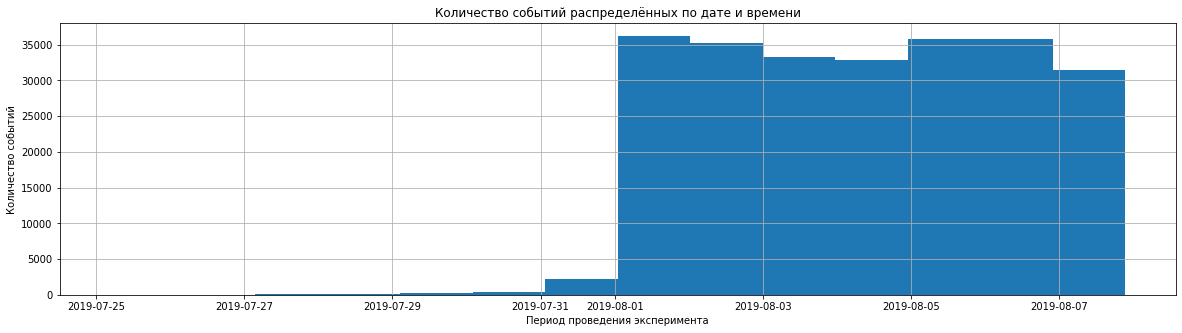

In [17]:
data['event_timestamp'].hist(figsize=(20, 5), bins=14)
plt.title('Количество событий распределённых по дате и времени')
plt.xlabel('Период проведения эксперимента')
plt.ylabel('Количество событий')
plt.show()

Данные не полные, в первую неделю число событий было очень мало, для изучения лучше взять вторую неделю с наибольшим количеством данных. 

In [18]:
data['date'] = data['date'].astype('datetime64')
data_1 = data.query('date > "2019-07-31"')

In [19]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240887 entries, 2826 to 243712
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       240887 non-null  object        
 1   device_id_hash   240887 non-null  int64         
 2   event_timestamp  240887 non-null  datetime64[ns]
 3   exp_id           240887 non-null  int64         
 4   date             240887 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 11.0+ MB


In [20]:
print('Данных осталось:', (data_1['event_name'].count()*100/244126).round(2),'%')
print('Данных удалили:', (100 - (data_1['event_name'].count()*100/244126)).round(2),'%')
print('Всего пользователей в логе осталось:',len(data_1['device_id_hash'].unique())) 
x = 100-(7534 * 100 / 7551)
print('Всего пользователей удалили: 0.2 %')

Данных осталось: 98.67 %
Данных удалили: 1.33 %
Всего пользователей в логе осталось: 7534
Всего пользователей удалили: 0.2 %


Не полные данные и дубликаты событий и пользователей составляют менее 2% от начальных данных их можно удалить.

In [21]:
#2.2.6 Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.
groop = data_1.pivot_table(index=['exp_id'], values='device_id_hash', aggfunc='nunique')#.reset_index()
display(groop)

,device_id_hash
exp_id,
246,2484
247,2513
248,2537


## Изучение воронки событий.

In [22]:
print('Количество событий в логах')
print( )
print(data_1['event_name'].value_counts());

Количество событий в логах

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64


In [23]:
#event = data.groupby('event_name')['device_id_hash'].nunique().sort_values(ascending=False)
event = (data_1.pivot_table(index=['event_name'], values='device_id_hash', aggfunc='nunique')
         .sort_values(by ='device_id_hash',  ascending=False)
        )

In [24]:
event['share'] = (event['device_id_hash'] / 7419).round(2)
event['share'] = event['share'].round(2)
(
    event.style.set_caption('Количество пользователей совершивших событие')
    .set_table_styles([{'selector': 'caption', 'props': [('color', 'black'), ('font-size', '15px')]}])
)

,device_id_hash,share
event_name,,
MainScreenAppear,7419,1.000000
OffersScreenAppear,4593,0.620000
CartScreenAppear,3734,0.500000
PaymentScreenSuccessful,3539,0.480000
Tutorial,840,0.110000


In [25]:
event['share_by_steps(%)'] = [100, 61.9, 81.3, 94.8, 11.3]

In [26]:
(
event.head(4).style.set_caption('Количество пользователей совершивших событие')
    .set_table_styles([{'selector': 'caption', 'props': [('color', 'black'), ('font-size', '15px')]}])
    
)

,device_id_hash,share,share_by_steps(%)
event_name,,,
MainScreenAppear,7419,1.000000,100.000000
OffersScreenAppear,4593,0.620000,61.900000
CartScreenAppear,3734,0.500000,81.300000
PaymentScreenSuccessful,3539,0.480000,94.800000


На втором этапе теряется около 38% пользователей, больше чем у остальных событий. Событие Tutorial не является частью воронки, он служит только как обучающее руководство по пользованию приложением и этот этап многие пользователи пропускают.

In [ ]:
y = ["Payment Screen Successful", "Cart Screen Appear", "Offers Screen Appear", "Main Screen Appear"] 
x = [95, 81, 62, 100]
x_max = 110
x_min = 0
for idx, val in enumerate(x):
    plt.barh(y[idx], x[idx], left = idx-3)
plt.xlim(x_min, x_max)
plt.title('График воронки пользователей доходящих от первого события до оплаты на каждом шаге в %.');
share_data = dict(
    number=[100, 62, 50, 48],
    share=["Main Screen Appear", "Offers Screen Appear", "Cart Screen Appear", "Payment Screen Successful"])

fig = px.funnel(share_data, x='number', y='share',
                title='Beskar Forging Services Inc.')
fig = px.funnel(share_data, y='share', x='number', 
                template="simple_white",
                title='График воронки пользователей доходящих от первого события до оплаты в %.',
                labels={"Stage": ""})    
fig.show()
print(3539 / 7419 * 100, '% пользователей доходит от первого события до оплаты.')

Вывод: От первого события до последнего доходит около 48% пользователей, при этом на втором этапе теряется наибольшие их количество 38%,  на остальных теряется по 12% пользователей.

## Изучение результатов эксперимента

,device_id_hash
exp_id,
246,2484
247,2513
248,2537


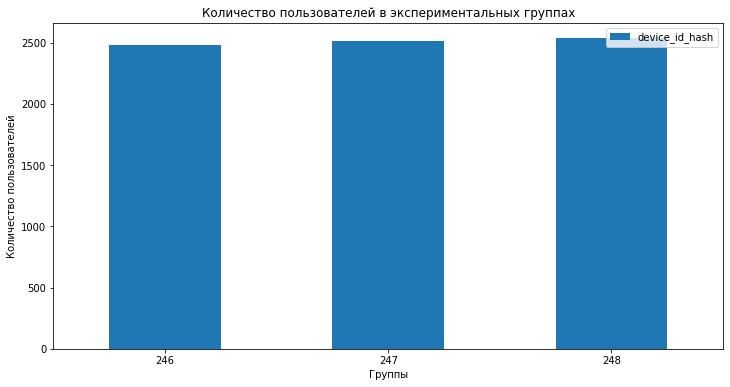

In [29]:
display(groop)
groop.plot(kind='bar', y='device_id_hash', figsize=(12, 6),  rot = 0)
plt.title('Количество пользователей в экспериментальных группах')
plt.xlabel('Группы')
plt.ylabel('Количество пользователей')
plt.show()

Группы 246 и 247 являются контрольными, в 246 находятся 2484, а 247 около 2513 пользователей. В группе 248 пользователи использовавшие приложения с изменёнными шрифтами, в ней 2537 пользователей.

In [30]:
print('Количество пользователей в различных группах различается не более чем на', int(2513/2484),'%.')

Количество пользователей в различных группах различается не более чем на 1 %.


In [31]:
a1 = data_1.query('exp_id == 246')

event_a1 = (a1.pivot_table(index=['event_name'], values='device_id_hash', aggfunc='nunique')
         .sort_values(by ='device_id_hash',  ascending=False)
        )
#event_a1['share'] = (event_a1['device_id_hash'] / event_a1['device_id_hash'].sum())
event_a1['share'] = (event_a1['device_id_hash'] / 2450)
event_a1['share'] = event_a1['share'].round(2)
event_a1

,device_id_hash,share
event_name,,
MainScreenAppear,2450,1.00
OffersScreenAppear,1542,0.63
CartScreenAppear,1266,0.52
PaymentScreenSuccessful,1200,0.49
Tutorial,278,0.11


In [32]:
a2 = data_1.query('exp_id == 247')

event_a2 = (a2.pivot_table(index=['event_name'], values='device_id_hash', aggfunc='nunique')
         .sort_values(by ='device_id_hash',  ascending=False)
        )
#event_a2['share'] = (event_a2['device_id_hash'] / event_a2['device_id_hash'].sum())
event_a2['share'] = (event_a2['device_id_hash'] / 2476)
event_a2['share'] = event_a2['share'].round(2)
event_a2

,device_id_hash,share
event_name,,
MainScreenAppear,2476,1.00
OffersScreenAppear,1520,0.61
CartScreenAppear,1238,0.50
PaymentScreenSuccessful,1158,0.47
Tutorial,283,0.11


In [33]:
b = data_1.query('exp_id == 248')
event_b = (b.pivot_table(index=['event_name'], values='device_id_hash', aggfunc='nunique')
         .sort_values(by ='device_id_hash',  ascending=False)
        )
#event_b['share'] = (event_b['device_id_hash'] / event_b['device_id_hash'].sum())
event_b['share'] = (event_b['device_id_hash'] / 2493)
event_b['share'] = event_b['share'].round(2)
event_b

,device_id_hash,share
event_name,,
MainScreenAppear,2493,1.00
OffersScreenAppear,1531,0.61
CartScreenAppear,1230,0.49
PaymentScreenSuccessful,1181,0.47
Tutorial,279,0.11


In [34]:
share_event  = pd.DataFrame(
({
'event_name': ['MainScreenAppear','OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful'], 
'share_246': [100, 63, 52, 49],
'share_247': [100, 61, 50, 47],
'share_248': [100, 61, 49, 47]})
    );

In [35]:
display(
    (share_event.style.background_gradient(subset=['share_246', 'share_247', 'share_248'], cmap='Blues')
     .set_caption('Сравнение воронок пользователей в событиях по группам в %.')
      .set_table_styles([{'selector': 'caption', 'props': [('color', 'black'), ('font-size', '15px')]}])
     .hide_index())
    )

event_name,share_246,share_247,share_248
MainScreenAppear,100,100,100
OffersScreenAppear,63,61,61
CartScreenAppear,52,50,49
PaymentScreenSuccessful,49,47,47


Вывод: При сравнении воронок групп можно сделать вывод что большой разницы между старыми и новыми шрифтами нет. В 246 контрольной группе на всех этапах есть 2% отличие от 247 контрольной группы и 248 экспериментальной, у 247 отличие от экспериментальной практически нет.

In [36]:
def stat_krit(msa1, x1, mas2, x2):
    
    alpha = 0.05  # критический уровень статистической значимости
    
    purchases = np.array([x1, x2])
    leads = np.array([msa1, mas2])

    p1 = purchases[0] / leads[0]
    p2=  purchases[1] / leads[1]
    p_combined = (purchases[0] + purchases[1]) / (leads[0] + leads[1])
    difference = p1 - p2

    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/leads[0] + 1/leads[1]))

    distr = st.norm(0, 1)

    p_value = (1-distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
             'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        )

### Сравниваем контрольные группы друг с другом, группу 246 с группой 247. 

Сформулируем гипотезы:

- Нулевая: различий между контрольными группами 246 и 247 в событии Offers Screen Appear нет.
- Альтернативная: различия между контрольными группами 246 и 247 в событии Offers Screen Appear есть.

In [37]:
#OffersScreenAppear
stat_krit(2450, 1542, 2476, 1520)

p-значение:  0.2622344959255778
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


- Нулевая: различий между контрольными группами 246 и 247 в событии Cart Screen Appear нет.
- Альтернативная: различия между контрольными группами 246 и 247 в событии Cart Screen Appear есть.

In [38]:
#CartScreenAppear
stat_krit(2450, 1266, 2476, 1238)

p-значение:  0.24012327015939383
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


- Нулевая: различий между контрольными группами 246 и 247 в событии Payment Screen Successful нет.
- Альтернативная: различия между контрольными группами 246 и 247 в событии Payment Screen Successful есть.

In [39]:
#PaymentScreenSuccessful
stat_krit(2450, 1200, 2476, 1158)

p-значение:  0.12044299485641763
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Вывод: Причин отвергать нулевую гипотезу и считать, что между контрольными группами 246 и 247 есть различия, нет.

### Сравниваем контрольную группу 246 с исследуемой группой 248.

Сформулируем гипотезы:

- Нулевая: различий между контрольной группой 246 и исследуемой группой 248 в событии Offers Screen Appear нет.
- Альтернативная: различия между  контрольной группой  246 и исследуемой группой 248 в событии Offers Screen Appear есть.

In [40]:
#OffersScreenAppear
stat_krit(2493, 1531, 2450, 1542)

p-значение:  0.2684281587249231
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


- Нулевая: различий между  контрольной группой  246 и исследуемой группой 248  в событии Cart Screen Appear нет.
- Альтернативная: различия между контрольной группой  246 и исследуемой группой 248 в событии Cart Screen Appear есть.

In [41]:
#CartScreenAppear 
stat_krit(2493, 1266, 2450, 1230)

p-значение:  0.6844103115682585
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


- Нулевая: различий между  контрольной группой  246 и исследуемой группой 248 в  событии Payment Screen Successful нет.
- Альтернативная: различия между  контрольной группой  246 и исследуемой группой 248 в  событии Payment Screen Successful есть.

In [42]:
#PaymentScreenSuccessful
stat_krit(2493, 1181, 2450, 1200)

p-значение:  0.2582638437556217
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Вывод: Причин отвергать нулевую гипотезу и считать, что между контрольной группой 246 и исследуемой группой 248 есть различия, нет.

### Сравниваем контрольную группу 247 с исследуемой группой 248.

Сформулируем гипотезы:

- Нулевая: различий между контрольной группой 247 и исследуемой группой 248 в событии Offers Screen Appear нет.
- Альтернативная: различия между контрольной группой 247 и исследуемой группой 248 в событии Offers Screen Appear есть

In [43]:
#OffersScreenAppear
stat_krit(2493, 1531, 2476, 1520)

p-значение:  0.9869365252844515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


- Нулевая: различий между  контрольной группой  247 и исследуемой группой 248  в событии Cart Screen Appear нет.
- Альтернативная: различия между контрольной группой  247 и исследуемой группой 248 в событии Cart Screen Appear есть.

In [44]:
#CartScreenAppear 
stat_krit(2493, 1230, 2476, 1238)

p-значение:  0.6408180183192491
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


- Нулевая: различий между  контрольной группой  247 и исследуемой группой 248 в  событии Payment Screen Successful нет.
- Альтернативная: различия между  контрольной группой  247 и исследуемой группой 248 в  событии Payment Screen Successful есть.

In [45]:
#PaymentScreenSuccessful
stat_krit(2493, 1181, 2476, 1158)

p-значение:  0.6699208079332859
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Вывод: Причин отвергать нулевую гипотезу и считать, что между контрольной группой 247 и исследуемой группой 248 есть различия, нет.

### Сравниваем обобщённую контрольную группу с исследуемой группой.

Сформулируем гипотезы:

- Нулевая: различий между контрольной группой исследуемой группой в событии Offers Screen Appear нет.
- Альтернативная: различия между контрольной группой и исследуемой группой в событии Offers Screen Appear есть

In [46]:
#OffersScreenAppear
stat_krit(2493, 1531, 4926,  3062)

p-значение:  0.5308589432077624
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


- Нулевая: различий между контрольной группой и исследуемой группой в событии Cart Screen Appear нет.
- Альтернативная: различия между контрольной группой и исследуемой группой в событии Cart Screen Appear есть.

In [47]:
#CartScreenAppear
stat_krit(2493, 1230, 4926,  2505)

p-значение:  0.21781510823139483
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


- Нулевая: различий между контрольной группой и исследуемой группой в событии Payment Screen Successful нет.
- Альтернативная: различия между контрольной группой и исследуемой группой в событии Payment Screen Successful есть.

In [48]:
#PaymentScreenSuccessful             
stat_krit(4926, 2358, 2493, 1181)

p-значение:  0.6863094718086811
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Вывод: Причин отвергать нулевую гипотезу и считать, что между объединенной контрольной группой и исследуемой группой есть различия, нет.

Было проведено 12 проверок статистических гипотез. При критерии в 5 % различий в полученных данных нет.

In [49]:
print(
    'Вероятность того, что хотя бы в одном из сравнений будет зафиксирован ложнопозитивный результат равна:',
)
print(0.5/12)

Вероятность того, что хотя бы в одном из сравнений будет зафиксирован ложнопозитивный результат равна:
0.041666666666666664


Критерий ниже 0.05 обычна используют в областях связанных с жизнью и здоровьем людей для большей надежности, но тут можно упустить связь между явлениями, а взяв критерий больше наоборот можно найти закономерность там где ее нет, поэтому 0.05 наиболее подходящий критерий в данной ситуации.

## Общий вывод.

По данным проведённых исследований можно подвести итоги:

- От главного экрана до экрана предложений доходят 62% пользователей, на этом этапе теряется наибольшее их количество 38%, на переходах к следующим этапов событий(экрана корзины и оплаты) теряется примерно по 12% пользователей. От начального количества пользователей приложением до оплаты остается 48%.
- Воронки контрольных и экспериментальной группы имеют не значительное различие на событии оплаты (Payment Screen Successful).
- Изменение шрифтов на потерю пользователей не влияет и при условии что есть свободные люди и ресурсы, а шрифты являются усторевшыми их можно заменить на новые, значимого влияния(положительного или отрицательного) на метрики эти изменения не окажут. 

По итогу шрифты менять можно к потери покупателей продукта это не приведет.